In [2]:
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# -------------------------------
# VIF 제거 함수 그대로 사용
# -------------------------------
def remove_high_vif_features(df, vif_threshold=10.0):
    """
    VIF를 계산하고 임계값보다 높은 VIF를 가진 변수를 반복적으로 제거합니다.
    df : 독립변수 DataFrame (종속변수 제외)
    """
    X = add_constant(df)

    print("다중공선성 변수 제거 프로세스 시작...")

    while True:
        features = X.columns.tolist()
        if "const" in features:
            features.remove("const")

        if len(features) <= 1:
            print("\n남은 변수가 1개 이하이므로 종료합니다.")
            break

        vif_data = pd.DataFrame()
        vif_data["feature"] = features
        vif_data["VIF"] = [
            variance_inflation_factor(X[features].values, i)
            for i in range(len(features))
        ]

        max_vif = vif_data["VIF"].max()

        if max_vif > vif_threshold:
            feature_to_remove = vif_data.loc[vif_data["VIF"].idxmax(), "feature"]
            X = X.drop(columns=[feature_to_remove])
            print(f"제거: {feature_to_remove} (VIF: {max_vif:.2f})")
        else:
            print(f"\n모든 변수의 VIF가 임계값 ({vif_threshold:.1f}) 이하입니다.")
            print(f"    - 최대 VIF: {max_vif:.2f}")
            break

    if "const" in X.columns:
        return X.drop(columns=["const"])
    return X


# -------------------------------
# 1) 데이터 불러오기
# -------------------------------
path = "../data/output_data/log.csv"
df = pd.read_csv(path)

# -------------------------------
# 2) 다중공선성 확인할 독립변수 X 만들기
#    - Date, 타깃컬럼(종가/목표값 등)은 제외
# -------------------------------
# 숫자형 컬럼만 선택
num_df = df.select_dtypes(include=[np.number]).copy()

# 타깃/제외하고 싶은 컬럼 이름들 (데이터에 맞게 필요하면 추가/삭제)
exclude_cols = [
    "y_target_log"
]
exclude_cols = [c for c in exclude_cols if c in num_df.columns]

X = num_df.drop(columns=exclude_cols)

# 분산 0인 상수 컬럼 제거 (VIF 계산 오류 방지)
X = X.loc[:, X.var() > 0]

print("원래 피처 수:", X.shape[1])

# -------------------------------
# 3) VIF 기반으로 다중공선성 높은 변수 제거
# -------------------------------
X_vif = remove_high_vif_features(X, vif_threshold=10.0)

print("\nVIF 제거 후 피처 수:", X_vif.shape[1])
print("남은 컬럼 목록:")
print(X_vif.columns.tolist())

# -------------------------------
# 4) 최종 VIF 표 한번 더 확인
# -------------------------------
X_const = add_constant(X_vif)
features = [c for c in X_const.columns if c != "const"]

vif_table = pd.DataFrame({
    "feature": features,
    "VIF": [variance_inflation_factor(X_const[features].values, i)
            for i in range(len(features))]
}).sort_values("VIF", ascending=False)

print("\n최종 VIF 테이블:")
print(vif_table)


원래 피처 수: 29
다중공선성 변수 제거 프로세스 시작...
제거: PAYEMS (VIF: 9840634.93)
제거: GC=F_Close (VIF: 6993540.26)
제거: CPIAUCSL (VIF: 5452505.83)
제거: SPY_High (VIF: 5047986.58)
제거: SHY_Close (VIF: 417566.51)
제거: TLT_Close (VIF: 152878.83)
제거: SPY_Low (VIF: 142784.97)
제거: DX-Y.NYB_Close (VIF: 26247.85)
제거: SPY_PER (VIF: 11957.03)
제거: GLD_Close (VIF: 10013.20)
제거: SPY_Volume (VIF: 5047.46)
제거: UNRATE (VIF: 4495.16)
제거: TLT_Volume (VIF: 3784.82)
제거: WTI_Spot (VIF: 2430.44)
제거: GLD_Volume (VIF: 1830.17)
제거: SHY_Volume (VIF: 998.04)
제거: SPY_PBR (VIF: 345.21)
제거: TNX (%) (VIF: 223.43)
제거: ^VIX_Close (VIF: 164.48)
제거: SPY_Volatility (VIF: 48.69)
제거: 기준금리 (VIF: 20.90)
제거: GLD_Volatility (VIF: 14.53)
제거: TLT_Volatility (VIF: 13.00)
제거: DX-Y.NYB_Volatility (VIF: 10.22)

모든 변수의 VIF가 임계값 (10.0) 이하입니다.
    - 최대 VIF: 7.91

VIF 제거 후 피처 수: 5
남은 컬럼 목록:
['GC=F_Volume', '^VIX_Volatility', 'GC=F_Volatility', 'SHY_Volatility', 'SPY_Premium_pct']

최종 VIF 테이블:
           feature       VIF
2  GC=F_Volatility  7.910635
0      G

In [3]:
X_vif

,GC=F_Volume,^VIX_Volatility,GC=F_Volatility,SHY_Volatility,SPY_Premium_pct
0,3.761200,0.845868,1.791759,0.039222,0.034974
1,3.178054,1.071584,2.292537,0.067658,0.015730
2,6.210600,0.845868,2.721292,0.131028,0.006895
3,5.786897,1.558145,3.763525,0.122215,-0.029572
4,5.552960,0.932164,2.240712,0.104361,0.017100
...,...,...,...,...,...
749,0.000000,1.040277,4.127134,0.039222,0.042058
750,6.489205,1.275363,4.234107,0.029558,0.028337
751,6.327937,1.311032,4.000036,0.076963,0.009694
752,6.478510,1.300192,3.353410,0.048793,0.053712


In [12]:
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

# 1) 윈도우 한글 폰트 경로 지정 (Malgun Gothic)
font_path = r"C:\Windows\Fonts\malgun.ttf"

font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

# 2) 마이너스 깨지는 것 방지
plt.rcParams['axes.unicode_minus'] = False



           feature       VIF
0      GC=F_Volume  6.665991
1  ^VIX_Volatility  6.576813
2  GC=F_Volatility  7.910635
3   SHY_Volatility  4.179003
4  SPY_Premium_pct  1.032187


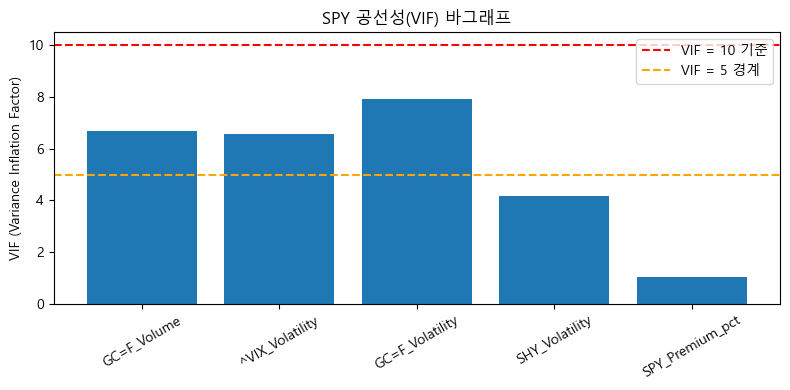

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor

# -----------------------------------
# 1. 공선성 검사 대상 컬럼 지정
# -----------------------------------
feature_cols = [
    "GC=F_Volume",
    "^VIX_Volatility",
    "GC=F_Volatility",
    "SHY_Volatility",
    "SPY_Premium_pct",
]

# df: 기존에 사용하던 데이터프레임
# 숫자형 + 결측 제거(필요시)
X = X_vif[feature_cols].astype(float).dropna().copy()

# -----------------------------------
# 2. VIF 계산
# -----------------------------------
vif_list = []
for i in range(X.shape[1]):
    vif_val = variance_inflation_factor(X.values, i)
    vif_list.append(vif_val)

df_vif = pd.DataFrame({
    "feature": feature_cols,
    "VIF": vif_list
})

print(df_vif)

# -----------------------------------
# 3. VIF 바그래프 시각화
# -----------------------------------
plt.figure(figsize=(8, 4))
plt.bar(df_vif["feature"], df_vif["VIF"])
plt.axhline(10, color="red", linestyle="--", label="VIF = 10 기준")
plt.axhline(5, color="orange", linestyle="--", label="VIF = 5 경계")

plt.ylabel("VIF (Variance Inflation Factor)")
plt.title("SPY 공선성(VIF) 바그래프")
plt.xticks(rotation=30)
plt.legend()
plt.tight_layout()
plt.show()


In [5]:
df

,Date,SPY_High,SPY_Low,SPY_Volume,SPY_Volatility,DX-Y.NYB_Close,GC=F_Close,GLD_Close,SHY_Close,TLT_Close,...,WTI_Spot,PAYEMS,UNRATE,TNX (%),기준금리,SPY_PER,SPY_PBR,CPIAUCSL,SPY_Premium_pct,y_target_log
0,2022-11-07,5.941670,5.928338,18.039229,1.798405,4.701571,7.424464,5.048894,4.389623,4.535606,...,4.519612,11.946071,1.280934,0.351642,1.386294,3.094219,1.280934,5.699467,0.034974,5.940040
1,2022-11-08,5.953555,5.934153,18.253931,2.128231,4.697020,7.445476,5.071730,4.390615,4.546481,...,4.486387,11.946071,1.280934,0.345432,1.386294,3.094219,1.280934,5.699467,0.015730,5.945421
2,2022-11-09,5.943167,5.923212,18.178552,2.143593,4.705468,7.444307,5.066700,4.392224,4.549763,...,4.451902,11.946071,1.280934,0.347200,1.386294,3.094219,1.280934,5.699467,0.006895,5.924603
3,2022-11-10,5.978987,5.954904,18.767498,2.341805,4.684074,7.467543,5.096691,4.397654,4.587515,...,4.460376,11.946071,1.280934,0.324183,1.386294,3.094219,1.280934,5.697023,-0.029572,5.978101
4,2022-11-11,5.989838,5.975361,18.357101,1.908063,4.666171,7.476472,5.103275,4.397408,4.583844,...,4.490208,11.946071,1.280934,0.323025,1.386294,3.094219,1.280934,5.697023,0.017100,5.987733
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749,2025-11-03,6.530586,6.522005,17.864073,1.925705,4.603869,8.294125,5.910200,4.415461,4.496917,...,4.123742,11.980050,1.458615,0.344015,1.386294,3.299534,1.611436,5.781879,0.042058,6.526993
750,2025-11-04,6.522034,6.514090,18.177679,1.853169,4.607368,8.280888,5.892528,4.415824,4.499143,...,4.117084,11.980050,1.458615,0.342809,1.386294,3.299534,1.611436,5.781879,0.028337,6.515068
751,2025-11-05,6.523357,6.513482,18.124999,2.039921,4.607168,8.289112,5.904026,4.415099,4.488187,...,4.100989,11.980050,1.458615,0.347624,1.386294,3.299534,1.611436,5.781879,0.009694,6.518528
752,2025-11-06,6.518232,6.505365,18.258577,2.267997,4.602467,8.289012,5.902825,4.416307,4.497139,...,4.098337,11.980050,1.458615,0.343093,1.386294,3.299534,1.611436,5.781879,0.053712,6.507740


In [6]:
# 1) X_vif에 Date 붙이기 (df에서 가져옴)
X_vif_with_date = df[["Date"]].join(X_vif)

# 2) Date 기준으로 y_target 붙이기
merged = X_vif_with_date.merge(
    df[["Date", "y_target_log"]],
    on="Date",
    how="inner"
)

# 3) 컬럼 순서 정리
cols = ["Date"] + [c for c in merged.columns if c not in ["Date", "y_target_log"]] + ["y_target_log"]
merged = merged[cols]

print(merged.head())
print(merged.shape)


         Date  GC=F_Volume  ^VIX_Volatility  GC=F_Volatility  SHY_Volatility  \
0  2022-11-07     3.761200         0.845868         1.791759        0.039222   
1  2022-11-08     3.178054         1.071584         2.292537        0.067658   
2  2022-11-09     6.210600         0.845868         2.721292        0.131028   
3  2022-11-10     5.786897         1.558145         3.763525        0.122215   
4  2022-11-11     5.552960         0.932164         2.240712        0.104361   

   SPY_Premium_pct  y_target_log  
0         0.034974      5.940040  
1         0.015730      5.945421  
2         0.006895      5.924603  
3        -0.029572      5.978101  
4         0.017100      5.987733  
(754, 7)


In [7]:
merged

,Date,GC=F_Volume,^VIX_Volatility,GC=F_Volatility,SHY_Volatility,SPY_Premium_pct,y_target_log
0,2022-11-07,3.761200,0.845868,1.791759,0.039222,0.034974,5.940040
1,2022-11-08,3.178054,1.071584,2.292537,0.067658,0.015730,5.945421
2,2022-11-09,6.210600,0.845868,2.721292,0.131028,0.006895,5.924603
3,2022-11-10,5.786897,1.558145,3.763525,0.122215,-0.029572,5.978101
4,2022-11-11,5.552960,0.932164,2.240712,0.104361,0.017100,5.987733
...,...,...,...,...,...,...,...
749,2025-11-03,0.000000,1.040277,4.127134,0.039222,0.042058,6.526993
750,2025-11-04,6.489205,1.275363,4.234107,0.029558,0.028337,6.515068
751,2025-11-05,6.327937,1.311032,4.000036,0.076963,0.009694,6.518528
752,2025-11-06,6.478510,1.300192,3.353410,0.048793,0.053712,6.507740


In [8]:
merged["Date"] = pd.to_datetime(merged["Date"])
merged = merged.set_index("Date")

In [9]:
merged.index

DatetimeIndex(['2022-11-07', '2022-11-08', '2022-11-09', '2022-11-10',
               '2022-11-11', '2022-11-14', '2022-11-15', '2022-11-16',
               '2022-11-17', '2022-11-18',
               ...
               '2025-10-27', '2025-10-28', '2025-10-29', '2025-10-30',
               '2025-10-31', '2025-11-03', '2025-11-04', '2025-11-05',
               '2025-11-06', '2025-11-07'],
              dtype='datetime64[ns]', name='Date', length=754, freq=None)

사용 컬럼: Index(['GC=F_Volume', '^VIX_Volatility', 'GC=F_Volatility', 'SHY_Volatility',
       'SPY_Premium_pct', 'y_target_log'],
      dtype='object')


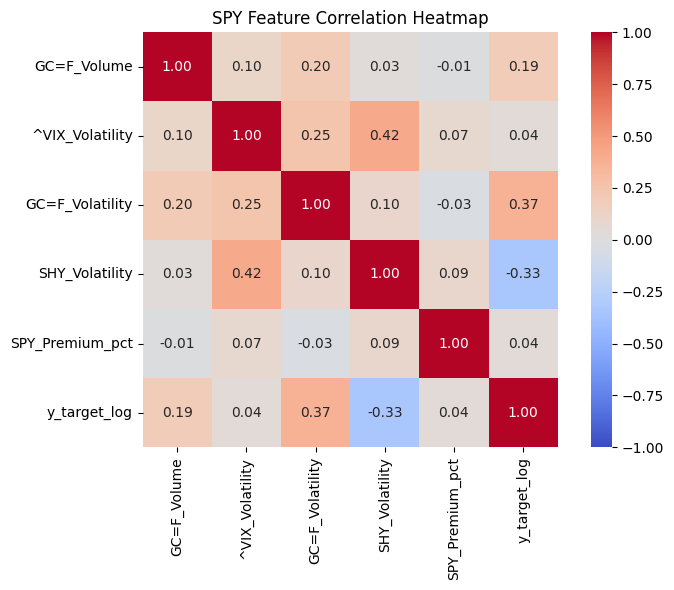

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  # 히트맵용

# df 가 이미 로드되어 있다고 가정
# df = pd.read_csv("...")
df = merged
# 1. 숫자형 컬럼만 선택 (Date 제외)
num_cols = df.select_dtypes(include=[np.number]).columns
print("사용 컬럼:", num_cols)

corr = df[num_cols].corr()

# 2. 히트맵 그리기
plt.figure(figsize=(8, 6))
sns.heatmap(
    corr,
    annot=True,        # 상관계수 숫자 표시
    fmt=".2f",         # 소수점 2자리
    cmap="coolwarm",   # 색상맵
    vmin=-1, vmax=1,   # -1~1 스케일 고정
    square=True
)

plt.title("SPY Feature Correlation Heatmap")
plt.tight_layout()
plt.show()


In [11]:
# 저장
# merged.to_csv("../preprocessing/log공선성제거_Final_data.csv", index=True, encoding="utf-8-sig")